In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

In [2]:
# Load data
data = pd.read_csv("take_home_data/data/insurance.csv")

In [3]:
# Data characteristics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1004 non-null   int64  
 1   sex       1004 non-null   object 
 2   bmi       1004 non-null   float64
 3   children  1004 non-null   int64  
 4   smoker    1004 non-null   object 
 5   region    1004 non-null   object 
 6   charges   1004 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 55.0+ KB


In [4]:
# Sample observations
data.head()

,age,sex,bmi,children,smoker,region,charges
0,45,female,25.175,2,no,northeast,9095.068
1,36,female,30.020,0,no,northwest,5272.176
2,64,female,26.885,0,yes,northwest,29330.983
3,46,male,25.745,3,no,northwest,9301.894
4,19,male,31.920,0,yes,northwest,33750.292


In [5]:
# Check sex values
data["sex"].value_counts()

male      508
female    496
Name: sex, dtype: int64

In [6]:
# Check smoker values
data["smoker"].value_counts()

no     791
yes    213
Name: smoker, dtype: int64

In [7]:
# Check region values
data["region"].value_counts()

southeast    276
southwest    255
northwest    248
northeast    225
Name: region, dtype: int64

In [8]:
# Change sex to dummy valued 1 for male, 0 for female
data["sex"] = data["sex"].map({"male": 1, "female": 0})

In [9]:
# Change smoker to dummy valued 1 for male, 0 for female
data["smoker"] = data["smoker"].map({"yes": 1, "no": 0})

In [10]:
# Make sure everything went fine
data.head()

,age,sex,bmi,children,smoker,region,charges
0,45,0,25.175,2,0,northeast,9095.068
1,36,0,30.020,0,0,northwest,5272.176
2,64,0,26.885,0,1,northwest,29330.983
3,46,1,25.745,3,0,northwest,9301.894
4,19,1,31.920,0,1,northwest,33750.292


# Problem 1

In [11]:
# Note: the output looked worse when I looped, so I just made summaries in separate cells
# Southeast summary
data[data.region=="southeast"].describe().transpose()[["count", "mean", "std"]]

,count,mean,std
age,276.000,38.942,14.150
sex,276.000,0.529,0.500
bmi,276.000,33.401,6.690
children,276.000,1.011,1.126
smoker,276.000,0.268,0.444
charges,276.000,14952.590,13933.802


In [12]:
# Southwest summary
data[data.region=="southwest"].describe().transpose()[["count", "mean", "std"]]

,count,mean,std
age,255.000,40.000,14.044
sex,255.000,0.510,0.501
bmi,255.000,30.694,5.703
children,255.000,1.176,1.272
smoker,255.000,0.180,0.385
charges,255.000,12530.709,11592.095


In [13]:
# Northwest summary
data[data.region=="northwest"].describe().transpose()[["count", "mean", "std"]]

,count,mean,std
age,248.000,39.391,13.858
sex,248.000,0.488,0.501
bmi,248.000,29.242,5.194
children,248.000,1.185,1.186
smoker,248.000,0.190,0.393
charges,248.000,12609.897,11329.232


In [14]:
# Northeast summary
data[data.region=="northeast"].describe().transpose()[["count", "mean", "std"]]

,count,mean,std
age,225.000,38.831,13.851
sex,225.000,0.493,0.501
bmi,225.000,29.409,6.094
children,225.000,1.049,1.185
smoker,225.000,0.204,0.404
charges,225.000,13387.631,11126.066


In [15]:
# Generate dummies for regions
regions = ["northeast", "northwest", "southeast", "southwest"]
for i in regions:
    data[i] = data["region"] == i
    data[i] = data[i].map({True: 1, False:0})
data = data.drop(columns="region")

In [16]:
# Make sure everything went okay
data.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest
0,45,0,25.175,2,0,9095.068,1,0,0,0
1,36,0,30.020,0,0,5272.176,0,1,0,0
2,64,0,26.885,0,1,29330.983,0,1,0,0
3,46,1,25.745,3,0,9301.894,0,1,0,0
4,19,1,31.920,0,1,33750.292,0,1,0,0


# Problem 2

For our sample, each region is fairly close to the average age of 39, men make up 48-52% of each region, and the average person in each region has about one kid. Each region has a similar average BMI apart from the southeast, which is about 3 higher than the overall average. Similarly, each region has a similar smoking rate apart from the southeast, which is about 6% higher than the others. As we might expect, the southeast had the highest average charge value.

In [17]:
# Overall Statistics
data.describe().transpose()[["count", "mean", "std"]].head(6)

,count,mean,std
age,1004.000,39.297,13.971
sex,1004.000,0.506,0.500
bmi,1004.000,30.791,6.192
children,1004.000,1.105,1.193
smoker,1004.000,0.212,0.409
charges,1004.000,13408.084,12145.987


From this table, we can see that the average person in this data is in their late thirties and slightly overweight (30 BMI average). The number of men and women is roughly equal in the sample, and each person has about one kid. About one in five people in this sample smoke. From the histogram below, we can see that the majority of people have relatively low insurance charges, but the distribution has a long tail of people with higher insurance charges.

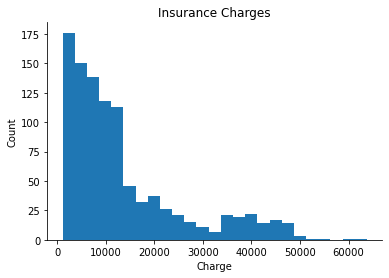

In [18]:
# Generate histogram of insurance charges
fig, ax = plt.subplots()
ax.hist(data["charges"], bins = 25)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Insurance Charges')
ax.set_xlabel('Charge')
ax.set_ylabel('Count')

plt.show()

# Problem 3

In [19]:
# Perform t-test on male and female ages
ttest_ind(data[data.sex==1]["age"], data[data.sex==0]["age"])

(-1.5860463168350691, 0.11304431459154292, 1002.0)

The t-test yields a p-value of 0.11, so we can not reject the null hypothesis that sex has no statistical relationhip with age in this sample.

# Problem 4

In [20]:
# Generate dummy variable for having any children
data["has_children"] = data["children"] > 0
data["has_children"] = data["has_children"].map({True: 1, False:0})

In [21]:
# Perform t-test for smokers with and without children
ttest_ind(data[data.has_children==1]["smoker"], data[data.has_children==0]["smoker"])

(-0.2201579269704336, 0.8257930078763985, 1002.0)

The t-test yields a p-value of 0.82, so we can not reject the null hypothesis that having children has no statistical relationship with whether or not people smoke.

# Problem 5

In [22]:
# Compute Variance Inflation Factor for model I build in problem 6
# Note: I omit the northwest variable because it's colinear with the other regions
data = data.drop(columns = "has_children")
independents = [i for i in data.columns if i != "charges"][:8]
X = data[independents]
vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

     feature    VIF
0        age  7.894
1        sex  2.019
2        bmi 11.018
3   children  1.838
4     smoker  1.278
5  northeast  1.731
6  northwest  1.806
7  southeast  2.138


To test for collinearity, I calculated the Varaince Inflation Factors for each variable that I will use in part 6 to model medical costs. In general, you would like $VIF < max(10, 1/(1-R^2) = max(10, 4.06) = 10$, so it appears that BMI has a collinearity problem. This is likely because of the high correlation with age and BMI, as when I dropped BMI from the calculation, age's VIF went to 2.5. This likely will not create any problems for the model I make in problem 6, but we should be wary of drawing inferences from the age and bmi coefficients, as they are highly correlated and models will have a hard time distinguishing one effect from the other. 

# Problem 6
For this part, I'll be generating linear regression models. For linear regression to provide unbiased parameter estimates, our data must be IID draws from a distribution, the errors need to be normally distributed, we can't have any endogenous/omitted variables, we can't have any autocorrelation/collinearity, and our model needs to correctly specify the linear relationship between the independent/dependent variables. 

In [23]:
# Simple regression including only primary variables of interest
res = smf.ols("charges ~ sex + smoker + age",
             data = data).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     878.8
Date:                Sun, 08 Aug 2021   Prob (F-statistic):          9.91e-280
Time:                        22:52:37   Log-Likelihood:                -10218.
No. Observations:                1004   AIC:                         2.044e+04
Df Residuals:                    1000   BIC:                         2.046e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2886.5862    652.779     -4.422      0.0

In [24]:
# Include more covariates
# Note: southwest is omitted because it's perfectly collinear with the other regions
# Note: assumed heteroskedasticity for more rigid standard error estimates
res = smf.ols("charges ~ sex + smoker + age + bmi + children + northeast + northwest + southeast",
             data = data).fit(cov_type="HC3")
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     232.8
Date:                Sun, 08 Aug 2021   Prob (F-statistic):          6.49e-222
Time:                        22:52:37   Log-Likelihood:                -10162.
No. Observations:                1004   AIC:                         2.034e+04
Df Residuals:                     995   BIC:                         2.039e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.303e+04   1238.294    -10.525      0.0

- Surprisingly enough, it appears that being male does not affect medical costs. Because sex has a p-value of 0.989, we aren't even close to rejecting the null hypothesis that sex has no impact on medical charges. This may have something to do with male correlation with smoking and higher BMIs.
- From this model, we can conclude that being a smoker has a strong impact on medical costs. The smoker variable has a p value that rounds to 0, and ceteris paribus we would expect that smoking increases medical costs by \$23,740.
- Because the p value of age rounds to zero, we can conclude that age has a strong statistical association with medical spending. Ceteris paribus, we expect each additional year to increase medical spending by \$263.67.

# Problem 7
Because we want make predictions about new data, we need to judge the effectiveness of our model by its performance out of sample. To create such a model, I would take the following steps:

- Split the data into training and test data
- Train models that yield the best cross-validated performance on the training data
- Take the trained models and evaluate how they perform on the test data
- Select the model that has the best performance on the test data, as this simulates out of sample performance

If we only care about our classification accuracy, we should set the cutoff to 50%. However, we should also consider that Type I and Type II error might not have the same costs to our business, i.e. falsely accepting expensive customers may be much more harmful than rejecting less costly customers. Therefore, it may be beneficial to reduce the threshold below 50% depending on the costs associated with taking the expensive customers.